44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Step 1 - Baseline Model Comparison (Sorted by ROC AUC):

                 Model  Accuracy  Precision (0)  Recall (0)  F1 (0)  \
0  Logistic Regression      0.79           0.85        0.88    0.86   
1                  ANN      0.79           0.84        0.88    0.86   
2        Random Forest      0.78           0.83        0.89    0.86   
3              XGBoost      0.78           0.83        0.87    0.85   

   Precision (1)  Recall (1)  F1 (1)  ROC AUC  
0           0.62        0.56    0.59     0.83  
1           0.62        0.53    0.57     0.83  
2           0.62        0.48    0.54     0.81  
3           0.59        0.53    0.55     0.81  


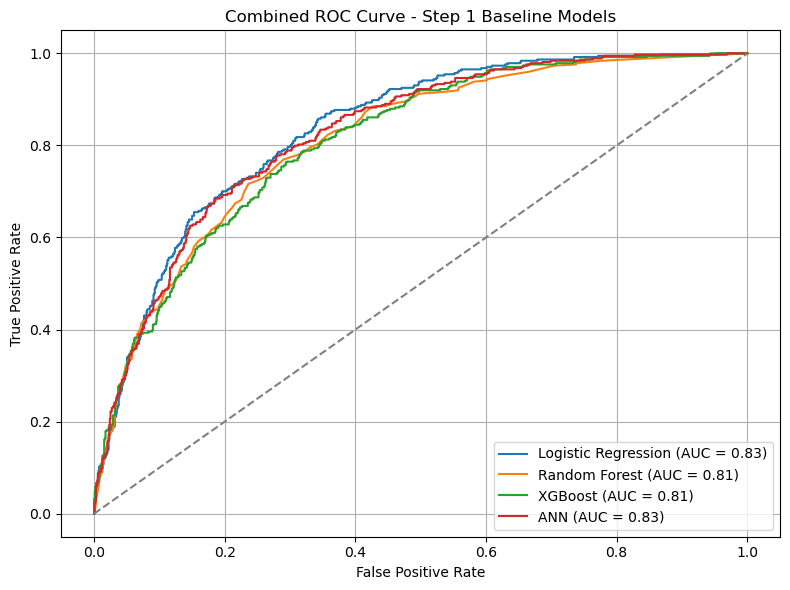

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
df = pd.read_csv("../data/Telecom Customers Churn.csv")
df.drop("customerID", axis=1, inplace=True)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(inplace=True)
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

# Encode categorical variables
categorical_cols = df.select_dtypes(include="object").columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X = df.drop("Churn", axis=1)
y = df["Churn"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model outputs storage
results = []
roc_curves = {}
y_probas = {}

### 1. Logistic Regression
logreg = LogisticRegression(max_iter=2000, random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)
y_proba_lr = logreg.predict_proba(X_test_scaled)[:, 1]
y_probas["Logistic Regression"] = y_proba_lr
fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
roc_curves["Logistic Regression"] = (fpr, tpr)

report = classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0)
results.append({
    "Model": "Logistic Regression",
    "Accuracy": np.round(report["accuracy"], 4),
    "Precision (0)": np.round(report["0"]["precision"], 4),
    "Recall (0)": np.round(report["0"]["recall"], 4),
    "F1 (0)": np.round(report["0"]["f1-score"], 4),
    "Precision (1)": np.round(report["1"]["precision"], 4),
    "Recall (1)": np.round(report["1"]["recall"], 4),
    "F1 (1)": np.round(report["1"]["f1-score"], 4),
    "ROC AUC": np.round(roc_auc_score(y_test, y_proba_lr), 4)
})

### 2. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]
y_probas["Random Forest"] = y_proba_rf
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_curves["Random Forest"] = (fpr, tpr)

report = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
results.append({
    "Model": "Random Forest",
    "Accuracy": np.round(report["accuracy"], 4),
    "Precision (0)": np.round(report["0"]["precision"], 4),
    "Recall (0)": np.round(report["0"]["recall"], 4),
    "F1 (0)": np.round(report["0"]["f1-score"], 4),
    "Precision (1)": np.round(report["1"]["precision"], 4),
    "Recall (1)": np.round(report["1"]["recall"], 4),
    "F1 (1)": np.round(report["1"]["f1-score"], 4),
    "ROC AUC": np.round(roc_auc_score(y_test, y_proba_rf), 4)
})

### 3. XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]
y_probas["XGBoost"] = y_proba_xgb
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
roc_curves["XGBoost"] = (fpr, tpr)

report = classification_report(y_test, y_pred_xgb, output_dict=True, zero_division=0)
results.append({
    "Model": "XGBoost",
    "Accuracy": np.round(report["accuracy"], 4),
    "Precision (0)": np.round(report["0"]["precision"], 4),
    "Recall (0)": np.round(report["0"]["recall"], 4),
    "F1 (0)": np.round(report["0"]["f1-score"], 4),
    "Precision (1)": np.round(report["1"]["precision"], 4),
    "Recall (1)": np.round(report["1"]["recall"], 4),
    "F1 (1)": np.round(report["1"]["f1-score"], 4),
    "ROC AUC": np.round(roc_auc_score(y_test, y_proba_xgb), 4)
})

### 4. ANN
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=100, batch_size=32, verbose=0, callbacks=[early_stop])

y_proba_ann = model.predict(X_test_scaled).flatten()
y_pred_ann = (y_proba_ann > 0.5).astype(int)
y_probas["ANN"] = y_proba_ann
fpr, tpr, _ = roc_curve(y_test, y_proba_ann)
roc_curves["ANN"] = (fpr, tpr)

report = classification_report(y_test, y_pred_ann, output_dict=True, zero_division=0)
results.append({
    "Model": "ANN",
    "Accuracy": np.round(report["accuracy"], 4),
    "Precision (0)": np.round(report["0"]["precision"], 4),
    "Recall (0)": np.round(report["0"]["recall"], 4),
    "F1 (0)": np.round(report["0"]["f1-score"], 4),
    "Precision (1)": np.round(report["1"]["precision"], 4),
    "Recall (1)": np.round(report["1"]["recall"], 4),
    "F1 (1)": np.round(report["1"]["f1-score"], 4),
    "ROC AUC": np.round(roc_auc_score(y_test, y_proba_ann), 4)
})

### Summary Table
df_results = pd.DataFrame(results)
df_results.sort_values(by="ROC AUC", ascending=False, inplace=True)
print("\nStep 1 - Baseline Model Comparison (Sorted by ROC AUC):\n")
print(df_results.round(2).reset_index(drop=True))

### Combined ROC Plot
plt.figure(figsize=(8, 6))
for model_name, (fpr, tpr) in roc_curves.items():
    auc = roc_auc_score(y_test, y_probas[model_name])
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Combined ROC Curve - Step 1 Baseline Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
